# グラフ分類 チュートリアル

[Graph Classification Tutorial — DGL 0.4 documentation](https://docs.dgl.ai/tutorials/basics/4_batch.html)

このチュートリアルでは、可変量・可変形の複数グラフを DGL でバッチ処理する方法を学びます。
同時に、簡単なグラフ分類タスクのためのグラフニューラルネットワークの構築も実例します。

**グラフ分類 (graph classification)** は、グラフ全体をみて「このグラフがどのカテゴリーなのか？」を当てる問題ですが、次のような多くの応用分野で利用できる重要な問題です。

- バイオインフォマティクス
- ケモインフォマティクス
- ソーシャルネットワーク分析
- アーバンコンピューティング
- サイバーセキュリティ

グラフニューラルネットワークをグラフ分類問題に適用する試みは、近年非常に盛んに行われています。この例としては、以下のような文献が挙げられます。

- [[1806.08804] Hierarchical Graph Representation Learning with Differentiable Pooling](https://arxiv.org/abs/1806.08804)
    - NeurIPS 2018
    - 既存手法では、グラフ埋め込み後のグラフの代表特徴量を生成するフェーズで、すべてのノードが均一に扱われてしまうことでグラフの階層的な構造を抽出できていなかった
    - グラフ特徴量をソフト クラスタリングのように集約する手法 DIFFPOOL を提案
- [[1811.01287] Towards Sparse Hierarchical Graph Classifiers](https://arxiv.org/abs/1811.01287)
    - NeruIPS 2018: Relational Representation Learning Workshop
    - DiffPool ではクラスタリングのコストが非常に高く、メモリの消費量も膨大なため、大規模グラフには適用できなかった
    - そこで、1) クラスタリングではなく Graph U-Net のような drops 構造による階層的集約、および 2) 集約階層ごとの "階層ベクトル" を readout する工夫で大幅な計算効率化を図った
- [[1811.09595] Spectral Multigraph Networks for Discovering and Fusing Relationships in Molecules](https://arxiv.org/abs/1811.09595)
    - 2018
    - 複数種類のエッジがある (heterogeneous な) マルチグラフに対して、Chebyshev GCN (ChebNet) の多項式をを 2 次元に拡張することで、学習可能とした
- [[1901.01343] Graph Neural Networks with convolutional ARMA filters](https://arxiv.org/abs/1901.01343)
- [[1901.01484] LanczosNet: Multi-Scale Deep Graph Convolutional Networks](https://arxiv.org/abs/1901.01484)
- [Graph U-Net | OpenReview](https://openreview.net/forum?id=HJePRoAct7)

## 簡単なグラフ分類タスク

このチュートリアルでは、以下の 8 種類のグラフの分類を目的とします。

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/dataset_overview.png)

まずは `data.MiniGCDataset` を利用して、グラフを生成しましょう。

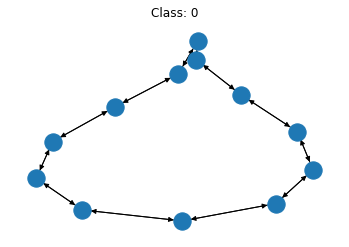

In [1]:
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
# A dataset with 80 samples, each graph is
# of size [10, 20]
dataset = MiniGCDataset(80, 10, 20)
graph, label = dataset[0]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

## グラフのミニバッチを形成

効率的にニューラルネットワークを学習するため、複数サンプルをまとめてミニバッチを作るプラクティスが広く知られています。一般的には、入力テンソル次元を固定してバッチを作成します。

- 例えば、2つの 28x28 の画像をバッチとするなら、`(2, 28, 28)` のテンソルを入力に与えます。

一方で、グラフデータのバッチ作成には 2 つの難しさがあります。

1. グラフはスパースである。
2. グラフは可変長データである (e.g. エッジ, ノード数)。

これらの問題に対処するため、DGL は `dgl.batch()` API を提供します。背景にあるのは、複数のグラフを (連結でない) 複数コンポーネントから成るひとつのグラフとして捉える発想です。次の図がそれを表しています。

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/batch.png)

以下の `collate` 関数を定義して、グラフのリストとラベルペアが与えられた時にグラフバッチを形成する処理を実装してみましょう。

In [2]:
import dgl

def collate(samples):
    """ グラフ列とラベル列のペアからバッチを作成する

    samples: (list(graph), list(labes))
    """
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

`dgl.batch()` の返り値もまたグラフです。

- テンソルのバッチもまたテンソルであるのと同様です。
- このクラス普遍性によって、グラフに対して動くコードがそのままグラフバッチに対しても動作することが保証されます。
- さらに重要なのは、DGL はすべてのノードとエッジのメッセージ パッシング処理を並列に行うので、とても効率的に計算効率を向上させることが出来るという点です。

## グラフ分類器

グラフ分類の処理フローは以下の通りです。

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/graph_classifier.png)

グラフのバッチ (図で言うところの 2 つのグラフを一緒のオブジェクトにまとめたもの) が与えられると、メッセージパッシング/グラフ畳み込みの処理が行われ、各ノードの特徴量が更新されていきます。このあと、ノード/エッジの属性値とともに、ノード特徴量がひとつのグラフを代表する特徴ベクトルにまとめられます。このステップは、readout や aggregation と呼ばれることがあります。最終的に、分類器 $g$ にグラフ特徴ベクトルを与えて、ラベルを予測します。

## グラフ畳み込み

GCN のチュートリアルでやったように、グラフ畳み込みを行います。チュートリアルのものと若干変更を加え、本来の GCN の実装を行います (以前のチュートリアルでは省略していたエッジの重み付け $c_i$ を考慮します)。

<以前>
$$
h_{v}^{(l+1)} = \text{ReLU}\left(b^{(l)}+\sum_{u\in\mathcal{N}(v)}h_{u}^{(l)}W^{(l)}\right)
$$

<今回>
$$
h_{v}^{(l+1)} = \text{ReLU}\left(b^{(l)}+\frac{1}{|\mathcal{N}(v)|}\sum_{u\in\mathcal{N}(v)}h_{u}^{(l)}W^{(l)}\right)
$$

次数で周辺ノードを正規化することで、次数の違うノード間の特徴量の扱われ方を均一にする作用が期待でき、実際今からやる実験にはより良い性能をもたらします。


> 以下の実装ではメッセージを受け取るタイミング (reduce) で正規化を適用していますが、DGL の公式実装をみてみると、特徴量を最初に正規化することでよりスマートに実装 (i.e. reduce も builtin 関数で書ける) ことがわかります。
>
> ref: https://docs.dgl.ai/en/latest/_modules/dgl/nn/pytorch/conv/graphconv.html#GraphConv

In [3]:
import dgl.function as fn
import torch
import torch.nn as nn

# builtin 関数によるメッセージ関数の実装
# 'h' の特徴をそのまま 'm' に送信する
msg = fn.copy_src(src='h', out='m')

def reduce(nodes):
    """平均をとってそのまま返す (sum じゃないのは次数で正規化しているから"""
    return {'h': torch.mean(nodes.mailbox['m'], 1)}

class NodeApplyModule(nn.Module):
    """数式中の h_u が与えられた時に、ReLU(b + W * h_u) を計算するレイヤー"""
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h' : h}

class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        g.ndata['h'] = feature
        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

## Readout と分類

このチュートリアルの例では、次数を初期ノード特徴量とします。グラフ畳み込みを2回行った後、バッチ内の各グラフに対して、すべてのノード特徴量を平均することでグラフの readout を実装します。

$$
h_g=\frac{1}{|\mathcal{V}|}\sum_{v\in\mathcal{V}}h_{v}
$$

DGL では `dlg.mean_nodes()` を使えば可変サイズのグラフのバッチに対して、この処理を簡単に実装出来ます。readout に続いて、一つの FC レイヤから構成される分類器に、グラフ特徴ベクトルを入力して分類のロジット値を得ます。

In [4]:
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()

        self.layers = nn.ModuleList([
            GCN(in_dim, hidden_dim, F.relu),
            GCN(hidden_dim, hidden_dim, F.relu)
        ])
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # 初期特徴量として次数を使う
        h =  g.in_degrees().view(-1, 1).float()
        for conv in self.layers:
            h = conv(g, h)
        g.ndata['h'] = h
        
        # readout
        h_g = dgl.mean_nodes(g, 'h')

        return self.classify(h_g)

## セットアップと訓練

10 ~ 20 ノードのグラフを 400 個生成した人工的なデータセットを用意します。320 グラフは訓練用で、残りの 80 はテスト用に使います。

In [5]:
import torch.optim as optim
from torch.utils.data import DataLoader

trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)

data_loader = DataLoader(trainset, batch_size=32, shuffle=True, collate_fn=collate)

model = Classifier(1, 256, trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()


epoch_losses = []
for epoch in range(80):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss: {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)


Epoch 0, loss: 2.0552
Epoch 1, loss: 1.9025
Epoch 2, loss: 1.8138
Epoch 3, loss: 1.7471
Epoch 4, loss: 1.6603
Epoch 5, loss: 1.5563
Epoch 6, loss: 1.4640
Epoch 7, loss: 1.4119
Epoch 8, loss: 1.3213
Epoch 9, loss: 1.2736
Epoch 10, loss: 1.1795
Epoch 11, loss: 1.1322
Epoch 12, loss: 1.0774
Epoch 13, loss: 1.0607
Epoch 14, loss: 1.0074
Epoch 15, loss: 0.9776
Epoch 16, loss: 0.9897
Epoch 17, loss: 0.9293
Epoch 18, loss: 0.9103
Epoch 19, loss: 0.8806
Epoch 20, loss: 0.8741
Epoch 21, loss: 0.8915
Epoch 22, loss: 0.8488
Epoch 23, loss: 0.8444
Epoch 24, loss: 0.8623
Epoch 25, loss: 0.8045
Epoch 26, loss: 0.7790
Epoch 27, loss: 0.7784
Epoch 28, loss: 0.7680
Epoch 29, loss: 0.7956
Epoch 30, loss: 0.7748
Epoch 31, loss: 0.7122
Epoch 32, loss: 0.6940
Epoch 33, loss: 0.6977
Epoch 34, loss: 0.6897
Epoch 35, loss: 0.6547
Epoch 36, loss: 0.6530
Epoch 37, loss: 0.6329
Epoch 38, loss: 0.6301
Epoch 39, loss: 0.6186
Epoch 40, loss: 0.6321
Epoch 41, loss: 0.6266
Epoch 42, loss: 0.6111
Epoch 43, loss: 0.593

学習曲線をプロットします。

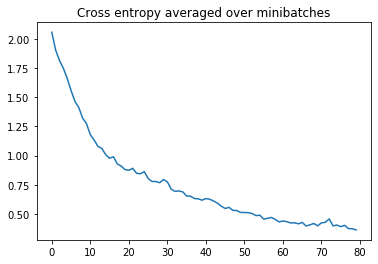

In [6]:
plt.title("Cross entropy averaged over minibatches")
plt.plot(epoch_losses)
plt.show()

テストデータに対する性能 (accuracy) を計算しましょう。 

In [7]:
model.eval()

# テストデータセットもバッチ化
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)

# バッチを入力 -> ロジットを取得 -> 確率に変換
probs_Y = torch.softmax(model(test_bg), 1)

# サンプリングによる予測と、期待値による予測
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)

print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))


Accuracy of sampled predictions on the test set: 67.5000%
Accuracy of argmax predictions on the test set: 85.000000%


モデルがどのようにグラフの内部表現を獲得しているのか気になるので、forward を明示的に再現することで内部表現を紐解きます。例えば、1 つ目のテストデータに対して `model` が出力する、グラフ全体の特徴ベクトル (readout 後の特徴) は以下の通りです。

In [12]:
def extract_embeddings(model, g):
    h_0 = g.in_degrees().view(-1, 1).float()
    h_1 = model.layers[0](g, h_0)
    h_2 = model.layers[1](g, h_1)
    g.ndata['h_2'] = h_2     
    h_g = dgl.mean_nodes(g, 'h_2')
    logits = model.classify(h_g)
    return h_0, h_1, h_2, h_g, logits

h_0, h_1, h_2, h_g, logits = extract_embeddings(model, test_X[0])
h_g

tensor([0.0000, 0.0000, 5.3050, 0.0000, 0.0000, 0.5174, 0.6102, 0.0000, 3.7493,
        0.0000, 0.2198, 5.6388, 0.0000, 4.5491, 3.4028, 0.0000, 0.0000, 4.4162,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.9395, 6.1114, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.4023, 0.0000, 0.0000, 0.0000,
        0.0000, 1.3746, 0.0000, 1.0927, 2.2880, 0.4896, 0.0000, 5.1687, 0.0000,
        6.5420, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.3276, 0.6558, 0.0000, 0.0000, 0.0000, 0.0000, 5.8528, 1.9928,
        0.9129, 0.0000, 0.0000, 5.8905, 0.0000, 0.0000, 3.5589, 0.0000, 0.0429,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.3837, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.9473, 0.0000, 0.0000, 0.0541, 0.0000,
        0.0000, 0.0000, 0.0673, 0.0000, 0.0000, 0.0000, 4.5964, 0.0000, 0.0000,
        0.0000, 0.0000, 0.6587, 0.0000, 

次元数が非常に多いので、潜在表現の可視化には t-SNE のような次元削減手法を使う必要があります。ここでは UMAP を利用して、グラフ全体を表す潜在表現を 2 次元の散布図としてプロットしてみます。

In [13]:

h_0, h_1, h_2, h_g, logits = extract_embeddings(model, test_bg)

In [14]:
import umap
from sklearn.manifold import TSNE

reducer = umap.UMAP()
# reducer = TSNE()

embedding = reducer.fit_transform(h_g.detach())
embedding.shape

/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


(80, 2)

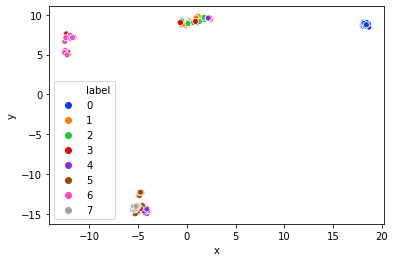

In [15]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.DataFrame({'x':embedding[:,0], 'y': embedding[:,1], 'label': test_Y.view(-1).int().numpy()})
palette = sns.color_palette("bright", 8)
sns.scatterplot(x='x', y='y', hue='label', data=df, legend='full', palette=palette)

## この次は？

ニューラルネットワークによるグラフ分類は比較的新しい分野です。より素晴らしい発見が生まれるのを待つ段階かもしれません。このタスクでは、埋め込み空間での構造的な類似度を保ったまま、異なるグラフに対して異なる潜在表現を獲得しなければなりません。もっと知りたくなった方は、2019 年の ICLR で発表された [How Powerful Are Graph Neural Networks?](https://arxiv.org/abs/1810.00826) を見てみるのが良いでしょう。